# Deconvolution with Cell2Location: Deconvolution of VISIUM data
Read set of CRC 10X VISIUM samples and run cell2location to perform deconvolution based on the gene expression cell type signatures generated in the 'Belgian_Cohort_ExpressionSigs' script.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           
DEPRECATION: git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import gc

data_type = 'float32'

# this line forces theano to use the GPU and should go before importing cell2location
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# if using the CPU uncomment this:
# os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=float32,openmp=True,force_device=True'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## Load Visium Data

In [4]:
sp_data_folder = '/content/drive/MyDrive/STEMREM205_Group_Project/Cell2Loc/sp_data_belgian_cohort/'
results_folder = '/content/drive/MyDrive/STEMREM205_Group_Project/Cell2Loc/results_belgian_cohort/'

regression_model_output = 'reference_signatures'
reg_path = f'{results_folder}{regression_model_output}/'

In [5]:
def read_and_qc(sample_name, path=sp_data_folder):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique()
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [6]:
# Read the list of spatial experiments
samples = {'sample_name': ['SN048_A121573_Rep1', 'SN048_A121573_Rep2',
                           'SN048_A416371_Rep1', 'SN048_A416371_Rep2',
                           'SN84_A120838_Rep1','SN84_A120838_Rep2',
                           'SN123_A551763_Rep1', 'SN123_A595688_Rep1',
                           'SN123_A798015_Rep1', 'SN123_A938797_Rep1',
                           'SN124_A595688_Rep2','SN124_A798015_Rep2',
                           'SN124_A938797_Rep2']}
sample_data = pd.DataFrame(data=samples)


# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
     slides.append(read_and_qc(i, path=sp_data_folder))

# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)

In [7]:
adata

AnnData object with n_obs × n_vars = 19514 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-SN048_A121573_Rep1', 'mean_counts-SN048_A121573_Rep1', 'log1p_mean_counts-SN048_A121573_Rep1', 'pct_dropout_by_counts-SN048_A121573_Rep1', 'total_counts-SN048_A121573_Rep1', 'log1p_total_counts-SN048_A121573_Rep1', 'n_cells_by_counts-SN048_A121573_Rep2', 'mean_counts-SN048_A121573_Rep2', 'log1p_mean_counts-SN048_A121573_Rep2', 'pct_dropout_by_counts-SN048_A121573_Rep2', 'total_counts-SN048_A121573_Rep2', 'log1p_total_counts-SN048_A121573_Rep2', 'n_cells_by_counts-SN048_A416371_Rep1', 'mean_counts-SN048_A416371_Rep1', 'log1p_mean_counts-SN048_A416371_Rep1', 'pct_dropout_by_counts-SN048_A416371_R

In [8]:
adata.var

feature_types  genome       SYMBOL     mt  \
ENSEMBL                                                        
ENSG00000243485  Gene Expression  GRCh38  MIR1302-2HG  False   
ENSG00000237613  Gene Expression  GRCh38      FAM138A  False   
ENSG00000186092  Gene Expression  GRCh38        OR4F5  False   
ENSG00000238009  Gene Expression  GRCh38   AL627309.1  False   
ENSG00000239945  Gene Expression  GRCh38   AL627309.3  False   
...                          ...     ...          ...    ...   
ENSG00000277836  Gene Expression  GRCh38   AC141272.1  False   
ENSG00000278633  Gene Expression  GRCh38   AC023491.2  False   
ENSG00000276017  Gene Expression  GRCh38   AC007325.1  False   
ENSG00000278817  Gene Expression  GRCh38   AC007325.4  False   
ENSG00000277196  Gene Expression  GRCh38   AC007325.2  False   

                 n_cells_by_counts-SN048_A121573_Rep1  \
ENSEMBL                                                 
ENSG00000243485                                     0   
ENSG00000237613                                     0   
ENSG00000186092                                     0   
ENSG00000238009                                    20   
ENSG00000239945                                     0   
...                                               ...   
ENSG00000277836                                     0   
ENSG00000278633                                     1   
ENSG00000276017                                     0   
ENSG00000278817                                    22   
ENSG00000277196                                    12   

                 mean_counts-SN048_A121573_Rep1  \
ENSEMBL                                           
ENSG00000243485                        0.000000   
ENSG00000237613                        0.000000   
ENSG00000186092                        0.000000   
ENSG00000238009                        0.009079   
ENSG00000239945                        0.000000   
...                                         ...   
ENSG00000277836                        0.000000   
ENSG00000278633                        0.000454   
ENSG00000276017                        0.000000   
ENSG00000278817                        0.010440   
ENSG00000277196                        0.005447   

                 log1p_mean_counts-SN048_A121573_Rep1  \
ENSEMBL                                                 
ENSG00000243485                              0.000000   
ENSG00000237613                              0.000000   
ENSG00000186092                              0.000000   
ENSG00000238009                              0.009038   
ENSG00000239945                              0.000000   
...                                               ...   
ENSG00000277836                              0.000000   
ENSG00000278633                              0.000454   
ENSG00000276017                              0.000000   
ENSG00000278817                              0.010386   
ENSG00000277196                              0.005432   

                 pct_dropout_by_counts-SN048_A121573_Rep1  \
ENSEMBL                                                     
ENSG00000243485                                100.000000   
ENSG00000237613                                100.000000   
ENSG00000186092                                100.000000   
ENSG00000238009                                 99.092147   
ENSG00000239945                                100.000000   
...                                                   ...   
ENSG00000277836                                100.000000   
ENSG00000278633                                 99.954607   
ENSG00000276017                                100.000000   
ENSG00000278817                                 99.001362   
ENSG00000277196                                 99.455288   

                 total_counts-SN048_A121573_Rep1  \
ENSEMBL                                            
ENSG00000243485                              0.0   
ENSG00000237613                              0.0   
ENSG00000186092                     

In [9]:
adata.obs

in_tissue  array_row  array_col  \
spot_id                                                                  
SN048_A121573_Rep1_AAACAAGTATCTCCCA-1          1         50        102   
SN048_A121573_Rep1_AAACACCAATAACTGC-1          1         59         19   
SN048_A121573_Rep1_AAACATTTCCCGGATT-1          1         61         97   
SN048_A121573_Rep1_AAACCCGAACGAAATC-1          1         45        115   
SN048_A121573_Rep1_AAACCGGGTAGGTACC-1          1         42         28   
...                                          ...        ...        ...   
SN124_A938797_Rep2_TTGTGGCCCTGACAGT-1          1         18         60   
SN124_A938797_Rep2_TTGTTAGCAAATTCGA-1          1         22         42   
SN124_A938797_Rep2_TTGTTCAGTGTGCTAC-1          1         24         64   
SN124_A938797_Rep2_TTGTTGTGTGTCAAGA-1          1         31         77   
SN124_A938797_Rep2_TTGTTTGTGTAAATTC-1          1          7         51   

                                                   sample  n_genes_by_counts  \
spot_id                                                                        
SN048_A121573_Rep1_AAACAAGTATCTCCCA-1  SN048_A121573_Rep1               5341   
SN048_A121573_Rep1_AAACACCAATAACTGC-1  SN048_A121573_Rep1               5674   
SN048_A121573_Rep1_AAACATTTCCCGGATT-1  SN048_A121573_Rep1               3170   
SN048_A121573_Rep1_AAACCCGAACGAAATC-1  SN048_A121573_Rep1               6756   
SN048_A121573_Rep1_AAACCGGGTAGGTACC-1  SN048_A121573_Rep1               4295   
...                                                   ...                ...   
SN124_A938797_Rep2_TTGTGGCCCTGACAGT-1  SN124_A938797_Rep2               5932   
SN124_A938797_Rep2_TTGTTAGCAAATTCGA-1  SN124_A938797_Rep2               6011   
SN124_A938797_Rep2_TTGTTCAGTGTGCTAC-1  SN124_A938797_Rep2               5444   
SN124_A938797_Rep2_TTGTTGTGTGTCAAGA-1  SN124_A938797_Rep2               4998   
SN124_A938797_Rep2_TTGTTTGTGTAAATTC-1  SN124_A938797_Rep2               5899   

                                       log1p_n_genes_by_counts  total_counts  \
spot_id                                                                        
SN048_A121573_Rep1_AAACAAGTATCTCCCA-1                 8.583355       17364.0   
SN048_A121573_Rep1_AAACACCAATAACTGC-1                 8.643826       22320.0   
SN048_A121573_Rep1_AAACATTTCCCGGATT-1                 8.061802        7669.0   
SN048_A121573_Rep1_AAACCCGAACGAAATC-1                 8.818334       27100.0   
SN048_A121573_Rep1_AAACCGGGTAGGTACC-1                 8.365440       12265.0   
...                                                        ...           ...   
SN124_A938797_Rep2_TTGTGGCCCTGACAGT-1                 8.688285       21543.0   
SN124_A938797_Rep2_TTGTTAGCAAATTCGA-1                 8.701513       22686.0   
SN124_A938797_Rep2_TTGTTCAGTGTGCTAC-1                 8.602453       17600.0   
SN124_A938797_Rep2_TTGTTGTGTGTCAAGA-1                 8.516993       15314.0   
SN124_A938797_Rep2_TTGTTTGTGTAAATTC-1                 8.682708       21057.0   

                                       log1p_total_counts  \
spot_id                                                     
SN048_A121573_Rep1_AAACAAGTATCTCCCA-1            9.762212   
SN048_A121573_Rep1_AAACACCAATAACTGC-1           10.013283   
SN048_A121573_Rep1_AAACATTTCCCGGATT-1            8.945072   
SN048_A121573_Rep1_AAACCCGAACGAAATC-1           10.207326   
SN048_A121573_Rep1_AAACCGGGTAGGTACC-1            9.414586   
...                                                   ...   
SN124_A938797_Rep2_TTGTGGCCCTGACAGT-1            9.977853   
SN124_A938797_Rep2_TTGTTAGCAAATTCGA-1           10.029548   
SN124_A938797_Rep2_TTGTTCAGTGTGCTAC-1            9.775711   
SN124_A938797_Rep2_TTGTTGTGTGTCAAGA-1            9.636588   
SN124_A938797_Rep2_TTGTTTGTGTAAATTC-1            9.955036   

                                       pct_counts_in_top_50_genes  \
spot_id                                                             
SN048_A121573_Rep1_AAACAAGTATCTCCCA-1                   25.662

## Mitochondrial Removal
Mitochondrial genes are removed for the spatial mapping.

In [10]:
# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
adata = adata[:, ~adata.var['mt'].values]

In [11]:
adata.var.shape

(36588, 82)

## Looking at QC Metrics

SN048_A121573_Rep1
SN048_A121573_Rep2
SN048_A416371_Rep1
SN048_A416371_Rep2
SN84_A120838_Rep1
SN84_A120838_Rep2
SN123_A551763_Rep1
SN123_A595688_Rep1
SN123_A798015_Rep1
SN123_A938797_Rep1
SN124_A595688_Rep2
SN124_A798015_Rep2
SN124_A938797_Rep2


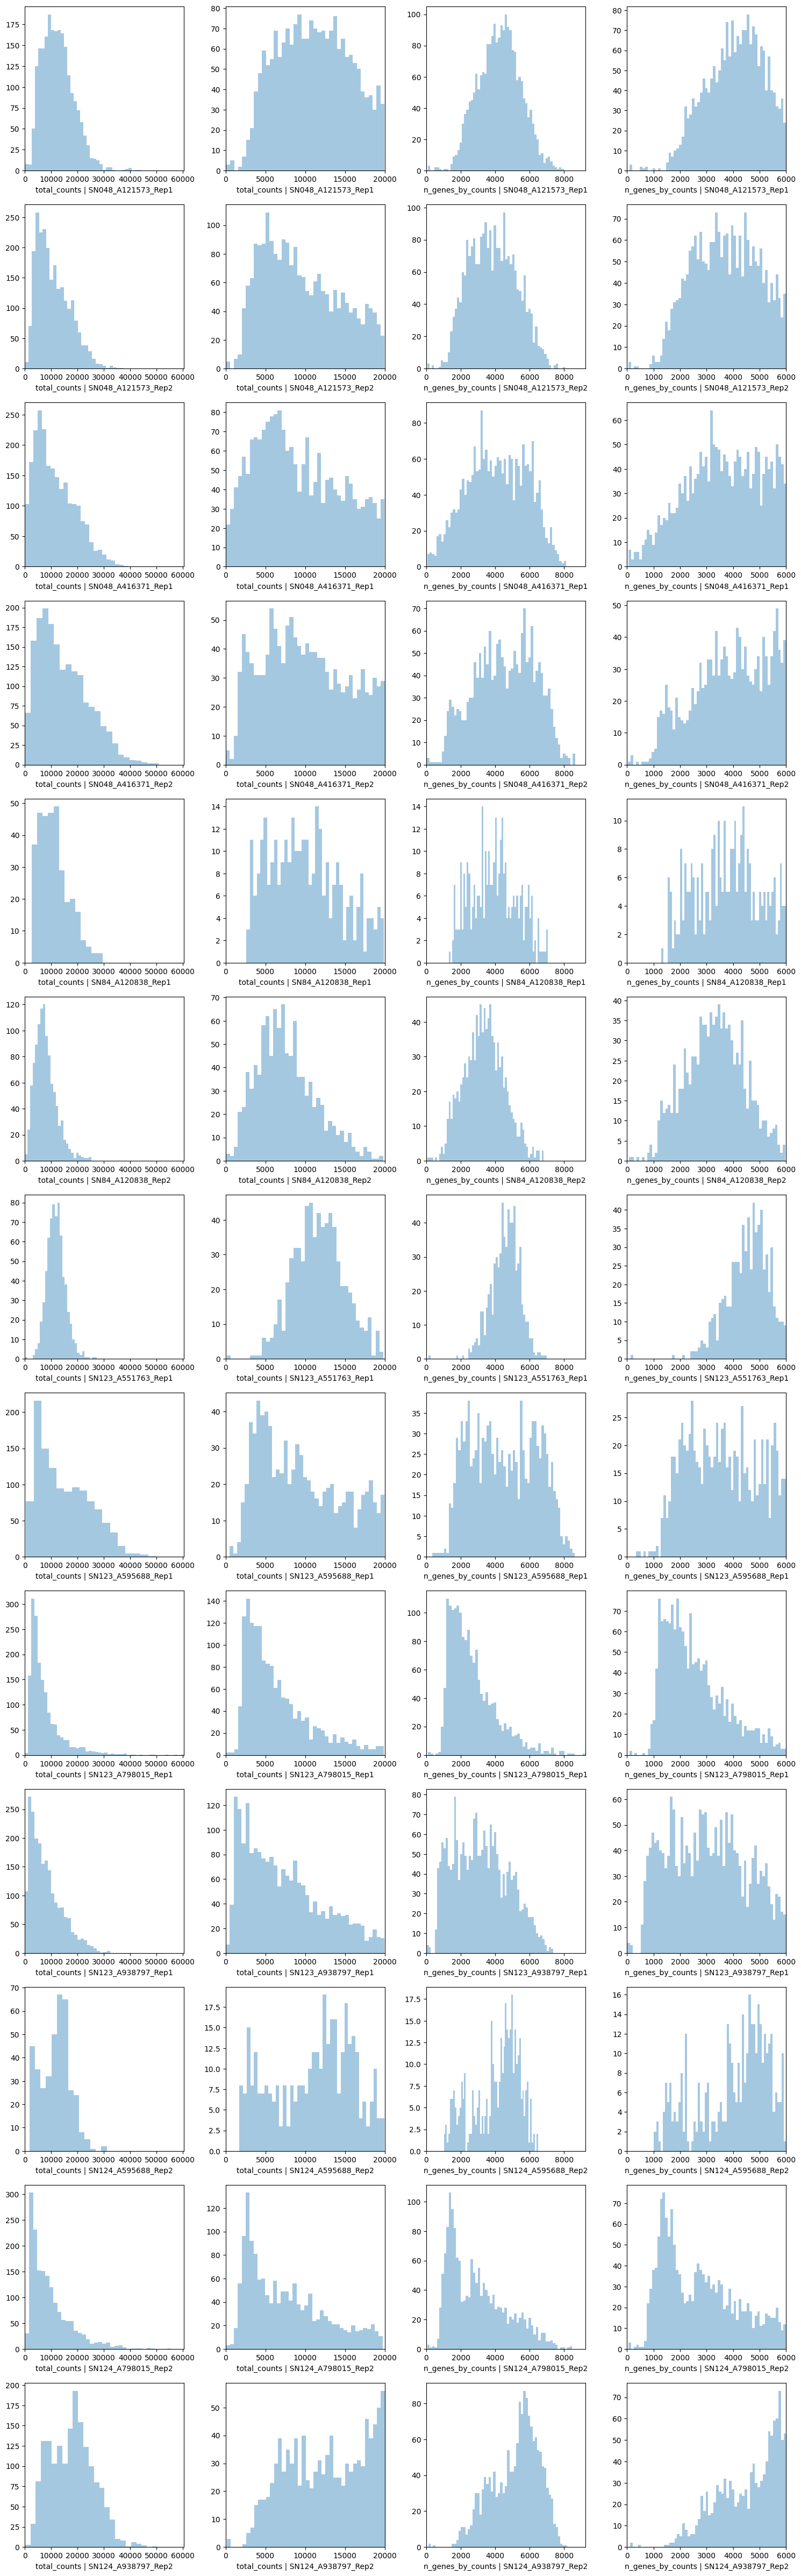

In [12]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')
    print(s)
    slide = select_slide(adata, s)
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

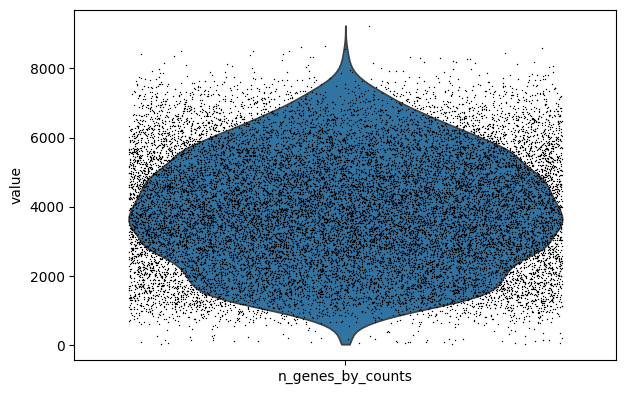

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts'],jitter=0.4)

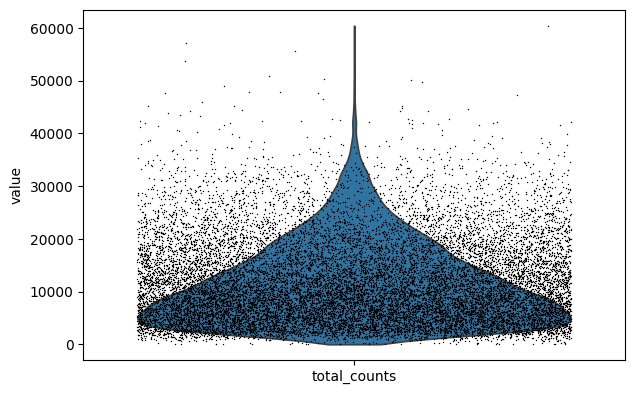

In [14]:
sc.pl.violin(adata, ['total_counts'],jitter=0.4)

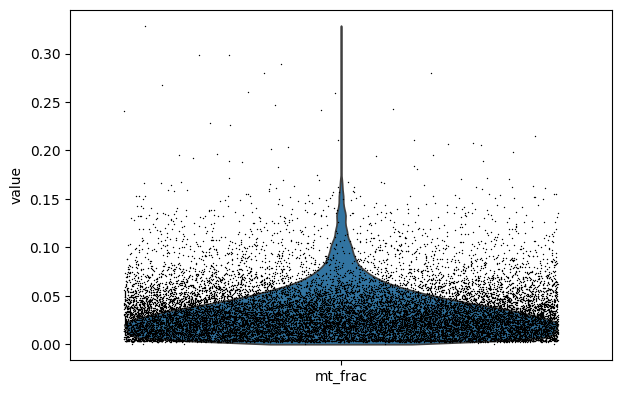

In [15]:
sc.pl.violin(adata, ['mt_frac'],jitter=0.4)

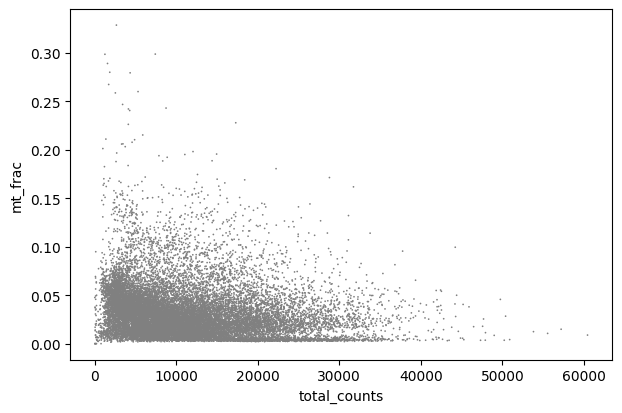

In [16]:
sc.pl.scatter(adata, x='total_counts', y='mt_frac')

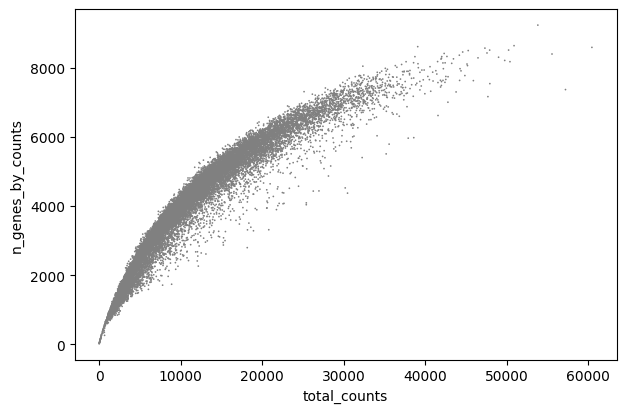

In [17]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## Visualize Visium Data in Spatial 2D + UMAP

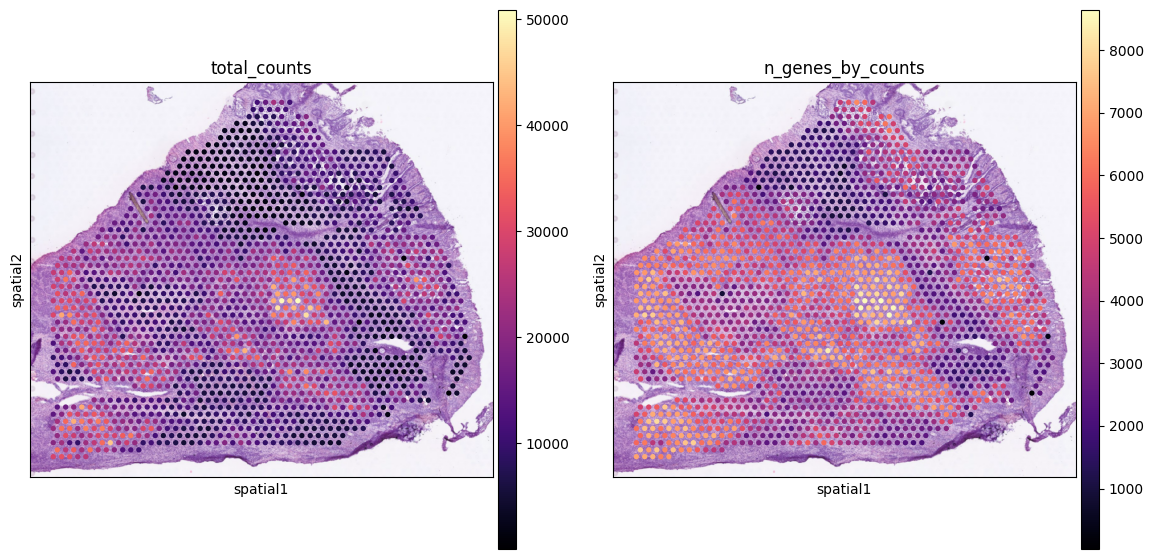

In [18]:
# Randomly picked a sample
slide = select_slide(adata, 'SN048_A416371_Rep2')

with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'white'}):
    sc.pl.spatial(slide, img_key = "hires", cmap='magma',
                  library_id=list(slide.uns['spatial'].keys())[0],
                  color=['total_counts', 'n_genes_by_counts'], size=1,
                  gene_symbols='SYMBOL', show=False, return_fig=True)

How to use scanpy to plot the expression of individual genes without the histology image.

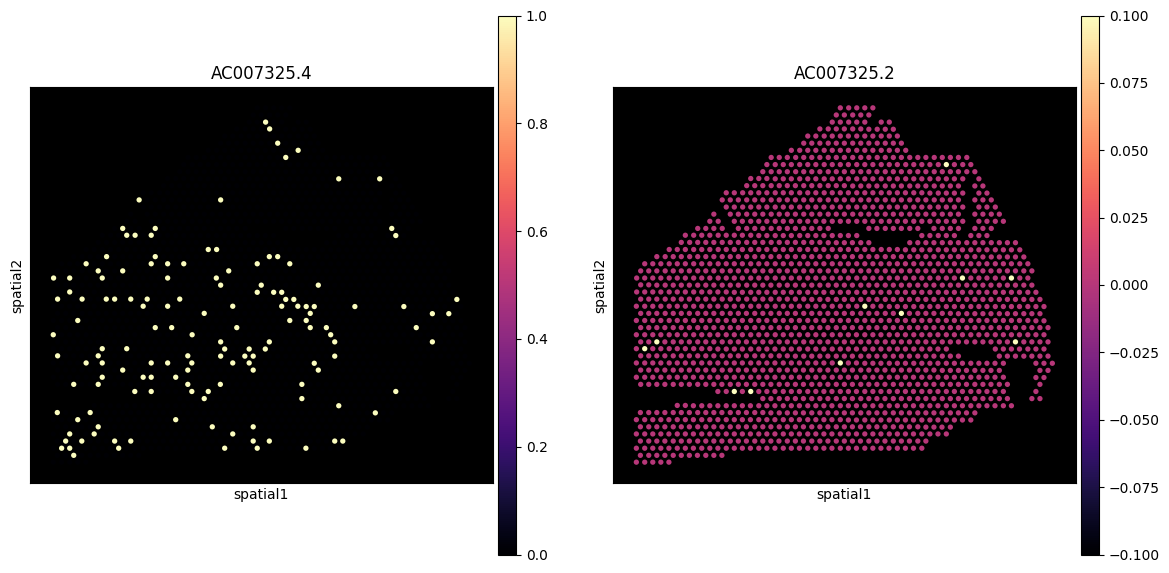

In [19]:
# Randomly picked two genes from dataset
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(slide,
                  color=["AC007325.4", "AC007325.2"], img_key=None, size=1,
                  vmin=0, cmap='magma', vmax='p99.0',
                  gene_symbols='SYMBOL'
                 )

Based on these results and the ones presented in the former QC in previous scripts, we decided to make the following filters in accordance with previous analysis:

In [20]:
adata = adata[(adata.obs.mt_frac < 0.5) & (adata.obs.total_counts > 500) & (adata.obs.total_counts < 45000), :]

In [21]:
# Add counts matrix as adata.raw
adata_vis = adata.copy()
adata_vis.raw = adata_vis

In [22]:
# For selecting two (or more) Visium samples, to speed up the analysis, one from each biological replicate.

#s = ['SN048_A416371_Rep1', 'SN048_A416371_Rep2']
#adata_vis = adata_vis[adata_vis.obs['sample'].isin(s),:]

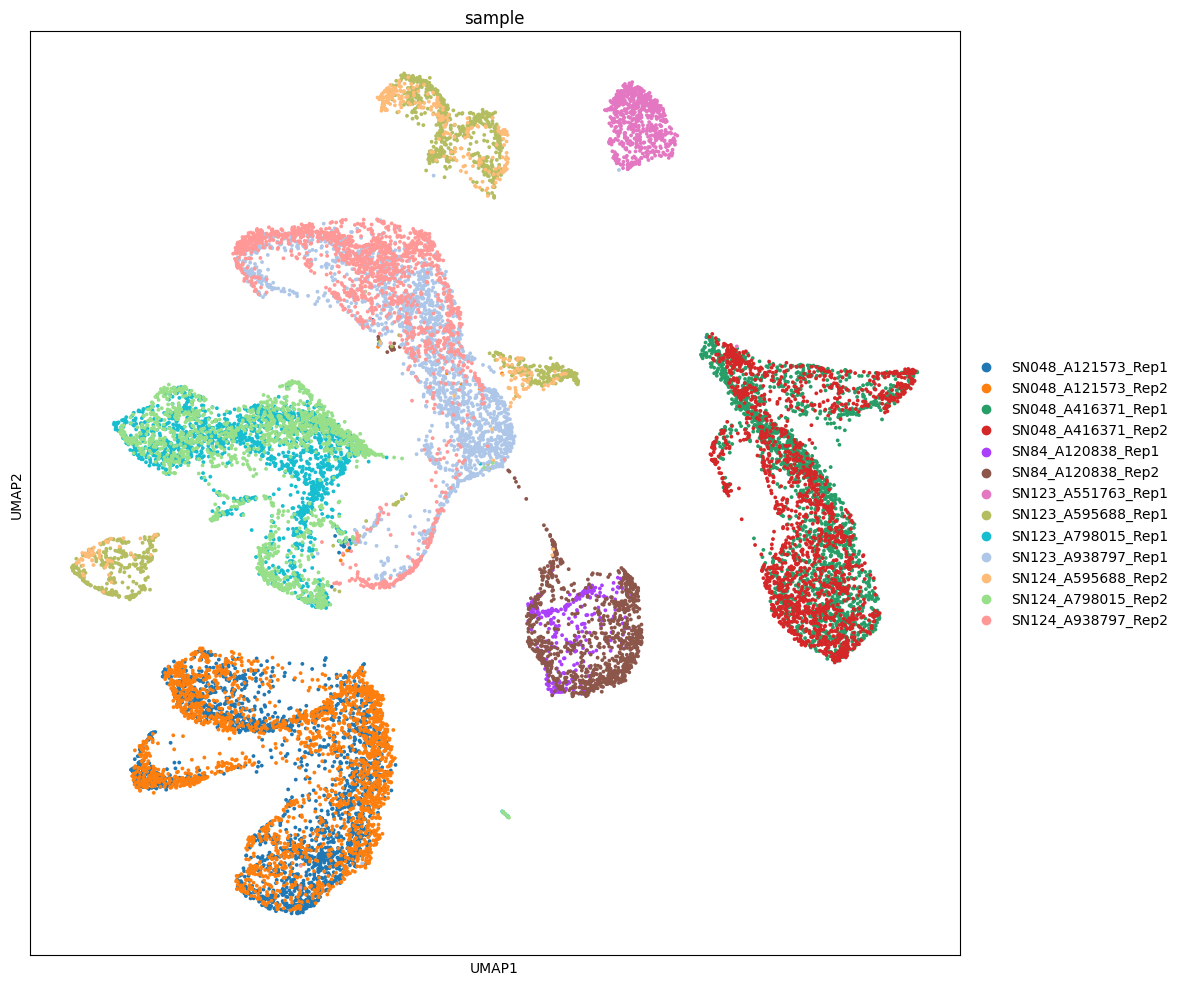

In [23]:
adata_vis_plt = adata_vis.copy()

# Log-transform (log(data + 1))
sc.pp.log1p(adata_vis_plt)

# Find highly variable genes within each sample
adata_vis_plt.var['highly_variable'] = False
for s in adata_vis_plt.obs['sample'].unique():

    adata_vis_plt_1 = adata_vis_plt[adata_vis_plt.obs['sample'].isin([s]), :]
    sc.pp.highly_variable_genes(adata_vis_plt_1, min_mean=0.0125, max_mean=5, min_disp=0.5, n_top_genes=1000)

    hvg_list = list(adata_vis_plt_1.var_names[adata_vis_plt_1.var['highly_variable']])
    adata_vis_plt.var.loc[hvg_list, 'highly_variable'] = True

# Scale the data ( (data - mean) / sd )
sc.pp.scale(adata_vis_plt, max_value=10)
# PCA, KNN construction, UMAP
sc.tl.pca(adata_vis_plt, svd_solver='arpack', n_comps=40, use_highly_variable=True)
sc.pp.neighbors(adata_vis_plt, n_neighbors = 20, n_pcs = 40, metric='cosine')
sc.tl.umap(adata_vis_plt, min_dist = 0.3, spread = 1)

with mpl.rc_context({'figure.figsize': [12, 12],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_vis_plt, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 1, #legend_loc='on data',
               legend_fontsize=10)

## Load reference cell type signature from snRNA-seq data and show UMAP of cells

In [24]:
f'{reg_path}sc.h5ad'

'/content/drive/MyDrive/STEMREM205_Group_Project/Cell2Loc/results_belgian_cohort/reference_signatures/sc.h5ad'

In [25]:
## scRNAseq reference (raw counts)
adata_scrna_raw = sc.read(f'{reg_path}sc.h5ad')

In [26]:
adata_scrna_raw.obs

Patient   Class   Sample Cell_type  \
KUL01-B_TGAGCATTCAGCTCTC   KUL01  Border  KUL01-B  Myeloids   
KUL19-N_GTACTCCCAGCCACCA   KUL19  Normal  KUL19-N  Myeloids   
KUL19-N_GTACTTTTCAGTCCCT   KUL19  Normal  KUL19-N  Myeloids   
KUL19-N_GTAGTCAAGTTGAGAT   KUL19  Normal  KUL19-N  Myeloids   
KUL19-N_GTCTTCGTCAACCATG   KUL19  Normal  KUL19-N  Myeloids   
...                          ...     ...      ...       ...   
KUL21-N_CCTCAGTAGCCGATTT   KUL21  Normal  KUL21-N   T cells   
KUL21-N_CGATGTAAGGACATTA   KUL21  Normal  KUL21-N   T cells   
KUL21-N_CGATGTACAGACAAGC   KUL21  Normal  KUL21-N   T cells   
KUL21-N_CGCCAAGCATAAAGGT   KUL21  Normal  KUL21-N   T cells   
KUL21-N_CTGAAGTTCATGTCTT   KUL21  Normal  KUL21-N   T cells   

                                 Cell_subtype  _indices  _scvi_batch  \
KUL01-B_TGAGCATTCAGCTCTC    Anti-inflammatory         0            0   
KUL19-N_GTACTCCCAGCCACCA    Anti-inflammatory         1            4   
KUL19-N_GTACTTTTCAGTCCCT    Anti-inflammatory         2            4   
KUL19-N_GTAGTCAAGTTGAGAT    Anti-inflammatory         3            4   
KUL19-N_GTCTTCGTCAACCATG    Anti-inflammatory         4            4   
...                                       ...       ...          ...   
KUL21-N_CCTCAGTAGCCGATTT  gamma delta T cells     27409            7   
KUL21-N_CGATGTAAGGACATTA  gamma delta T cells     27410            7   
KUL21-N_CGATGTACAGACAAGC  gamma delta T cells     27411            7   
KUL21-N_CGCCAAGCATAAAGGT  gamma delta T cells     27412            7   
KUL21-N_CTGAAGTTCATGTCTT  gamma delta T cells     27413            7   

                          _scvi_labels  
KUL01-B_TGAGCATTCAGCTCTC             0  
KUL19-N_GTACTCCCAGCCACCA             0  
KUL19-N_GTACTTTTCAGTCCCT             0  
KUL19-N_GTAGTCAAGTTGAGAT             0  
KUL19-N_GTCTTCGTCAACCATG             0  
...                                ...  
KUL21-N_CCTCAGTAGCCGATTT            39  
KUL21-N_CGATGTAAGGACATTA            39  
KUL21-N_CGATGTACAGACAAGC            39  
KUL21-N_CGCCAAGCATAAAGGT            39  
KUL21-N_CTGAAGTTCATGTCTT            39  

[27414 rows x 8 columns]

In [27]:
adata_scrna_raw

AnnData object with n_obs × n_vars = 27414 × 13651
    obs: 'Patient', 'Class', 'Sample', 'Cell_type', 'Cell_subtype', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'SYMBOL', 'n_cells', 'nonz_mean', 'mean', 'std'
    uns: 'Cell_subtype_colors', 'Cell_type_colors', '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'mod', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', '_scvi_extra_categorical_covs'
    varm: 'PCs', 'means_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg', 'stds_per_cluster_mu_fg'
    obsp: 'connectivities', 'distances'

In [28]:
#adata_scrna_raw.uns

In [29]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_scrna_raw.varm.keys():
    inf_aver = adata_scrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_scrna_raw.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_scrna_raw.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_scrna_raw.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_scrna_raw.uns['mod']['factor_names']
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

In [30]:
# normalise by average experiment scaling factor (corrects for sequencing depth)
inf_aver = inf_aver * adata_scrna_raw.uns['mod']['post_sample_means']['alpha_g_inverse'].mean()

In [31]:
inf_aver

Anti-inflammatory  BEST4+ Enterocytes  CD19+CD20+ B  CD4+ T cells  \
ENSEMBL                                                                         
FO538757.2           0.263685            1.652209      0.213976      0.191123   
AP006222.2           0.286083            0.594110      0.074495      0.031797   
SAMD11               0.004497            0.067918      0.003713      0.001515   
NOC2L                0.162681            1.393707      0.262150      0.185417   
PLEKHN1              0.006273            0.053705      0.002458      0.036940   
...                       ...                 ...           ...           ...   
AL592183.1           0.056473            0.289722      0.123239      0.051084   
AC007325.4           0.063541            0.044338      0.003915      0.011739   
AC004556.1           0.090915            0.339463      0.033600      0.014625   
AC233755.2           0.006910            0.135986      0.001968      0.002391   
AC233755.1           0.006038            0.137759      0.003897      0.001728   

            CD8+ T cells      CMS1      CMS2      CMS3      CMS4  \
ENSEMBL                                                            
FO538757.2      0.193170  0.657104  0.570970  0.763354  0.054498   
AP006222.2      0.073325  0.249705  0.165226  0.243111  0.124372   
SAMD11          0.002900  0.004955  0.014090  0.007735  0.051732   
NOC2L           0.197343  1.171525  0.638473  0.951544  0.643561   
PLEKHN1         0.017524  0.320054  0.151904  0.286860  0.190135   
...                  ...       ...       ...       ...       ...   
AL592183.1      0.024952  0.094181  0.078978  0.285022  0.063603   
AC007325.4      0.014056  0.094596  0.291824  0.131452  0.060206   
AC004556.1      0.010481  0.178339  0.400570  0.515622  0.112586   
AC233755.2      0.002742  0.003622  0.006076  0.003397  0.171119   
AC233755.1      0.003158  0.003349  0.007280  0.004855  0.156103   

            Enteric glial cells  ...  Stromal 2  Stromal 3  \
ENSEMBL                          ...                         
FO538757.2             0.271509  ...   0.459022   0.513383   
AP006222.2             0.290645  ...   0.224656   0.601949   
SAMD11                 0.015482  ...   0.596966   0.860817   
NOC2L                  0.206297  ...   0.422017   0.549518   
PLEKHN1                0.007829  ...   0.047443   0.003387   
...                         ...  ...        ...        ...   
AL592183.1             0.079698  ...   0.037787   0.126857   
AC007325.4             0.030786  ...   0.038678   0.220309   
AC004556.1             0.028220  ...   0.025189   0.092034   
AC233755.2             0.014277  ...   0.037549   0.001419   
AC233755.1             0.010265  ...   0.024117   0.002096   

            T follicular helper cells  T helper 17 cells  Tip-like ECs  \
ENSEMBL                                                                  
FO538757.2                   0.202195           0.222518      0.472391   
AP006222.2                   0.050013           0.060913      0.375144   
SAMD11                       0.008711           0.011392      0.019228   
NOC2L                        0.153387           0.272839      0.488857   
PLEKHN1                      0.018058           0.062072      0.025267   
...                               ...                ...           ...   
AL592183.1                   0.183193           0.019147      0.060917   
AC007325.4                   0.021902           0.026084      0.124965   
AC004556.1                   0.065256           0.048525      0.018122   
AC233755.2                   0.017021           0.015992      0.003446   
AC233755.1                   0.014235           0.011782      0.006213   

            Tuft cells   Unknown  Unspecified Plasma       cDC  \
ENSEMBL                                                          
FO538757.2    0.251209  0.142294            0.023572  0.833234   
AP006222.2    0.076202  0.093716            0.021902  0.253812   
SAMD11        0.100264  0.004499       

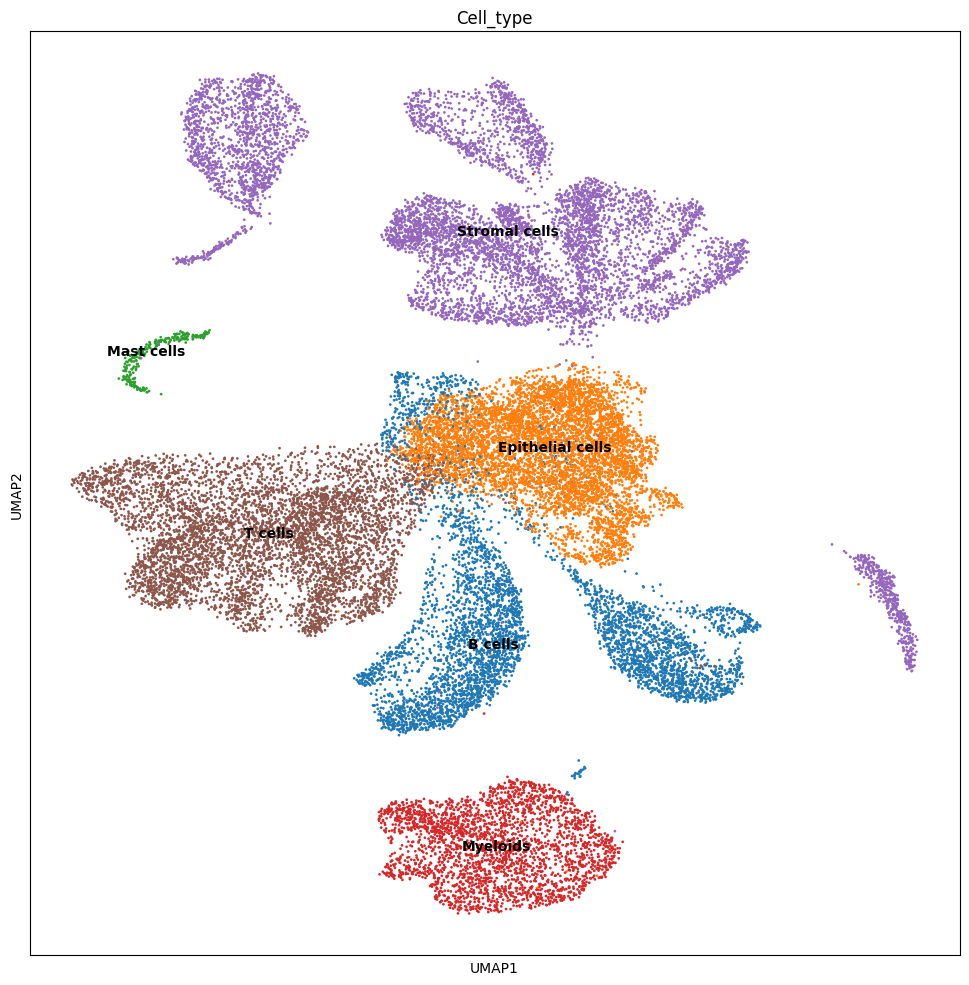

In [32]:
with mpl.rc_context({'figure.figsize': [12, 12],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_scrna_raw, color=['Cell_type'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

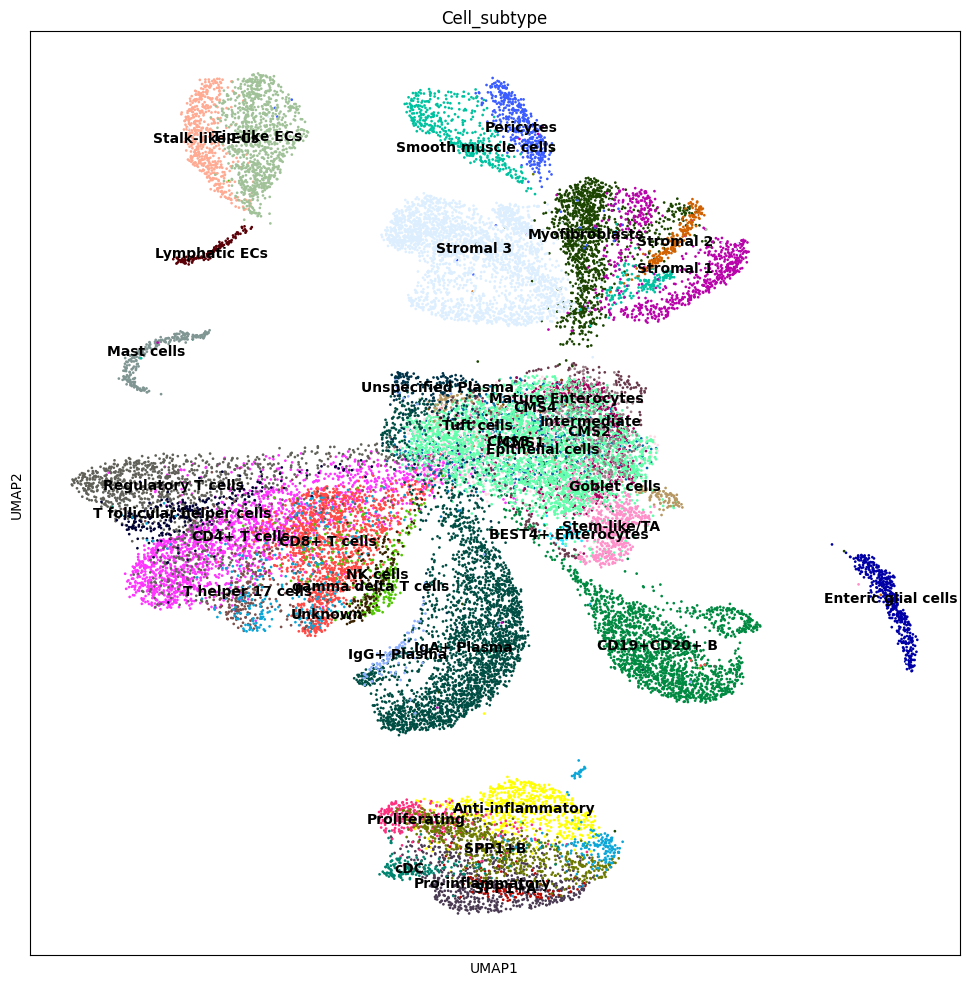

In [33]:
with mpl.rc_context({'figure.figsize': [12, 12],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_scrna_raw, color=['Cell_subtype'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

Performing gene selection

In [34]:
# selecting most informative genes based on specificity
selection_specificity = 0.20

# normalise expression signatures:
cell_state_df_norm = (inf_aver.T / inf_aver.sum(1)).T
# apply cut off:
cell_state_df_norm = (cell_state_df_norm > selection_specificity)

# check the number of markers per cell type
cell_state_df_norm.sum(0), (cell_state_df_norm.sum(1) > 0).sum(0)

(Anti-inflammatory             20
 BEST4+ Enterocytes           328
 CD19+CD20+ B                  36
 CD4+ T cells                   4
 CD8+ T cells                  14
 CMS1                          73
 CMS2                          33
 CMS3                          67
 CMS4                          45
 Enteric glial cells          130
 Epithelial cells              46
 Goblet cells                 116
 IgA+ Plasma                   95
 IgG+ Plasma                   87
 Intermediate                   2
 Lymphatic ECs                155
 Mast cells                    61
 Mature Enterocytes           109
 Myofibroblasts               163
 NK cells                      24
 Pericytes                    124
 Pro-inflammatory              21
 Proliferating                240
 Regulatory T cells            18
 SPP1+A                        69
 SPP1+B                        49
 Smooth muscle cells          139
 Stalk-like ECs               193
 Stem-like/TA                 907
 Stromal 1    

Don't need to keep the scRNA-seq data set and a list with slides in memory

In [35]:
del adata_scrna_raw, slides
gc.collect()

243067

Renaming columns and indices

In [36]:
adata_vis.var_names = adata_vis.var["SYMBOL"]
adata_vis.var.drop(columns='SYMBOL', inplace=True)

In [37]:
adata_vis.var

feature_types  genome     mt  \
SYMBOL                                        
MIR1302-2HG  Gene Expression  GRCh38  False   
FAM138A      Gene Expression  GRCh38  False   
OR4F5        Gene Expression  GRCh38  False   
AL627309.1   Gene Expression  GRCh38  False   
AL627309.3   Gene Expression  GRCh38  False   
...                      ...     ...    ...   
AC141272.1   Gene Expression  GRCh38  False   
AC023491.2   Gene Expression  GRCh38  False   
AC007325.1   Gene Expression  GRCh38  False   
AC007325.4   Gene Expression  GRCh38  False   
AC007325.2   Gene Expression  GRCh38  False   

             n_cells_by_counts-SN048_A121573_Rep1  \
SYMBOL                                              
MIR1302-2HG                                     0   
FAM138A                                         0   
OR4F5                                           0   
AL627309.1                                     20   
AL627309.3                                      0   
...                                           ...   
AC141272.1                                      0   
AC023491.2                                      1   
AC007325.1                                      0   
AC007325.4                                     22   
AC007325.2                                     12   

             mean_counts-SN048_A121573_Rep1  \
SYMBOL                                        
MIR1302-2HG                        0.000000   
FAM138A                            0.000000   
OR4F5                              0.000000   
AL627309.1                         0.009079   
AL627309.3                         0.000000   
...                                     ...   
AC141272.1                         0.000000   
AC023491.2                         0.000454   
AC007325.1                         0.000000   
AC007325.4                         0.010440   
AC007325.2                         0.005447   

             log1p_mean_counts-SN048_A121573_Rep1  \
SYMBOL                                              
MIR1302-2HG                              0.000000   
FAM138A                                  0.000000   
OR4F5                                    0.000000   
AL627309.1                               0.009038   
AL627309.3                               0.000000   
...                                           ...   
AC141272.1                               0.000000   
AC023491.2                               0.000454   
AC007325.1                               0.000000   
AC007325.4                               0.010386   
AC007325.2                               0.005432   

             pct_dropout_by_counts-SN048_A121573_Rep1  \
SYMBOL                                                  
MIR1302-2HG                                100.000000   
FAM138A                                    100.000000   
OR4F5                                      100.000000   
AL627309.1                                  99.092147   
AL627309.3                                 100.000000   
...                                               ...   
AC141272.1                                 100.000000   
AC023491.2                                  99.954607   
AC007325.1                                 100.000000   
AC007325.4                                  99.001362   
AC007325.2                                  99.455288   

             total_counts-SN048_A121573_Rep1  \
SYMBOL                                         
MIR1302-2HG                              0.0   
FAM138A                                  0.0   
OR4F5                                    0.0   
AL627309.1                              20.0   
AL627309.3                               0.0   
...                                      ...   
AC141272.1                               0.0   
AC023491.2                               1.0   
AC007325.1                               0.0   
AC007325.4                              23.0   
AC007325.2                              12.0   

             log1p_total_counts-SN048_A12157

In [38]:
inf_aver.index = inf_aver.index.rename('SYMBOL')

In [39]:
inf_aver

Anti-inflammatory  BEST4+ Enterocytes  CD19+CD20+ B  CD4+ T cells  \
SYMBOL                                                                          
FO538757.2           0.263685            1.652209      0.213976      0.191123   
AP006222.2           0.286083            0.594110      0.074495      0.031797   
SAMD11               0.004497            0.067918      0.003713      0.001515   
NOC2L                0.162681            1.393707      0.262150      0.185417   
PLEKHN1              0.006273            0.053705      0.002458      0.036940   
...                       ...                 ...           ...           ...   
AL592183.1           0.056473            0.289722      0.123239      0.051084   
AC007325.4           0.063541            0.044338      0.003915      0.011739   
AC004556.1           0.090915            0.339463      0.033600      0.014625   
AC233755.2           0.006910            0.135986      0.001968      0.002391   
AC233755.1           0.006038            0.137759      0.003897      0.001728   

            CD8+ T cells      CMS1      CMS2      CMS3      CMS4  \
SYMBOL                                                             
FO538757.2      0.193170  0.657104  0.570970  0.763354  0.054498   
AP006222.2      0.073325  0.249705  0.165226  0.243111  0.124372   
SAMD11          0.002900  0.004955  0.014090  0.007735  0.051732   
NOC2L           0.197343  1.171525  0.638473  0.951544  0.643561   
PLEKHN1         0.017524  0.320054  0.151904  0.286860  0.190135   
...                  ...       ...       ...       ...       ...   
AL592183.1      0.024952  0.094181  0.078978  0.285022  0.063603   
AC007325.4      0.014056  0.094596  0.291824  0.131452  0.060206   
AC004556.1      0.010481  0.178339  0.400570  0.515622  0.112586   
AC233755.2      0.002742  0.003622  0.006076  0.003397  0.171119   
AC233755.1      0.003158  0.003349  0.007280  0.004855  0.156103   

            Enteric glial cells  ...  Stromal 2  Stromal 3  \
SYMBOL                           ...                         
FO538757.2             0.271509  ...   0.459022   0.513383   
AP006222.2             0.290645  ...   0.224656   0.601949   
SAMD11                 0.015482  ...   0.596966   0.860817   
NOC2L                  0.206297  ...   0.422017   0.549518   
PLEKHN1                0.007829  ...   0.047443   0.003387   
...                         ...  ...        ...        ...   
AL592183.1             0.079698  ...   0.037787   0.126857   
AC007325.4             0.030786  ...   0.038678   0.220309   
AC004556.1             0.028220  ...   0.025189   0.092034   
AC233755.2             0.014277  ...   0.037549   0.001419   
AC233755.1             0.010265  ...   0.024117   0.002096   

            T follicular helper cells  T helper 17 cells  Tip-like ECs  \
SYMBOL                                                                   
FO538757.2                   0.202195           0.222518      0.472391   
AP006222.2                   0.050013           0.060913      0.375144   
SAMD11                       0.008711           0.011392      0.019228   
NOC2L                        0.153387           0.272839      0.488857   
PLEKHN1                      0.018058           0.062072      0.025267   
...                               ...                ...           ...   
AL592183.1                   0.183193           0.019147      0.060917   
AC007325.4                   0.021902           0.026084      0.124965   
AC004556.1                   0.065256           0.048525      0.018122   
AC233755.2                   0.017021           0.015992      0.003446   
AC233755.1                   0.014235           0.011782      0.006213   

            Tuft cells   Unknown  Unspecified Plasma       cDC  \
SYMBOL                                                           
FO538757.2    0.251209  0.142294            0.023572  0.833234   
AP006222.2    0.076202  0.093716            0.021902  0.253812   
SAMD11        0.100264  0.004499       

## Deconvolution

In [40]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [41]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [42]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  13   │
│         n_cells          │ 19443 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 12697 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                       batch State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ SN048_A121573_Rep1 │          0          │
│                     │ SN048_A121573_Rep2 │          1          │
│                     │ SN048_A416371_Rep1 │          2          │
│                     │ SN048_A416371_Rep2 │          3          │
│                     │ SN84_A120838_Rep1  │          4          │
│                     │ SN84_A120838_Rep2  │          5          │
│                     │ SN123_A551763_Rep1 │          6          │
│                     │ SN123_A595688_Rep1 │          7          │
│                     │ SN123_A798015_Rep1 │          8          │
│                     │ SN123_A938797_Rep1 │          9          │
│                     │ SN124_A595688_Rep2 │         10          │
│                     │ SN124_A798015_Rep2 │         11          │
│                     │ SN124_A938797_Rep2 │         12          │
└─────────────────────┴────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly 

Epoch 30000/30000: 100%|██████████| 30000/30000 [1:33:22<00:00,  5.33it/s, v_num=1, elbo_train=1.77e+8]

INFO: `Trainer.fit` stopped: `max_epochs=30000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [1:33:22<00:00,  5.35it/s, v_num=1, elbo_train=1.77e+8]


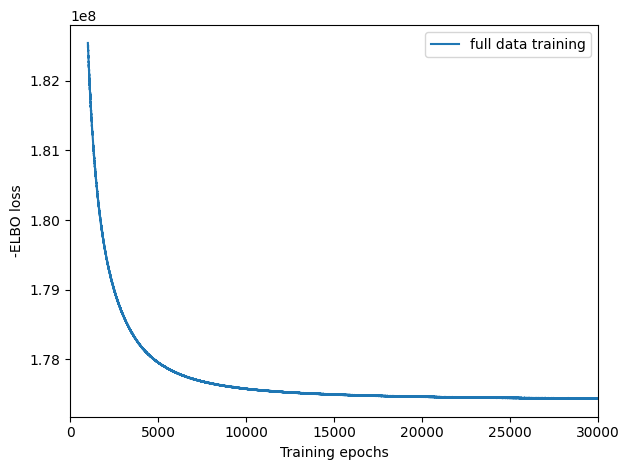

In [43]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

Exporting estimated posterior distributions of cell abundance and saving results:

In [50]:
run_name = f'{results_folder}cell2location_map'
f'{run_name}'

'/content/drive/MyDrive/STEMREM205_Group_Project/Cell2Loc/results_belgian_cohort/cell2location_map'

In [51]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:37<00:00, 26.77it/s]


'/content/drive/MyDrive/STEMREM205_Group_Project/Cell2Loc/results_belgian_cohort/cell2location_map/sp.h5ad'

The model and output h5ad can be loaded later like this:

In [52]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File                                                                                                      
         /content/drive/MyDrive/STEMREM205_Group_Project/Cell2Loc/results_belgian_cohort/cell2location_map/model.pt
         already downloaded                                                                                        


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/30000:   0%|          | 1/30000 [00:00<1:39:11,  5.04it/s, v_num=1]

INFO: `Trainer.fit` stopped: `max_steps=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:00<1:43:45,  4.82it/s, v_num=1]


In [49]:
mod

cell2location model with the following params: 
n_factors: 40 
n_batch: 13 
Training status: Trained

Sampling global variables, sample: 100%|██████████| 999/999 [00:33<00:00, 29.41it/s]


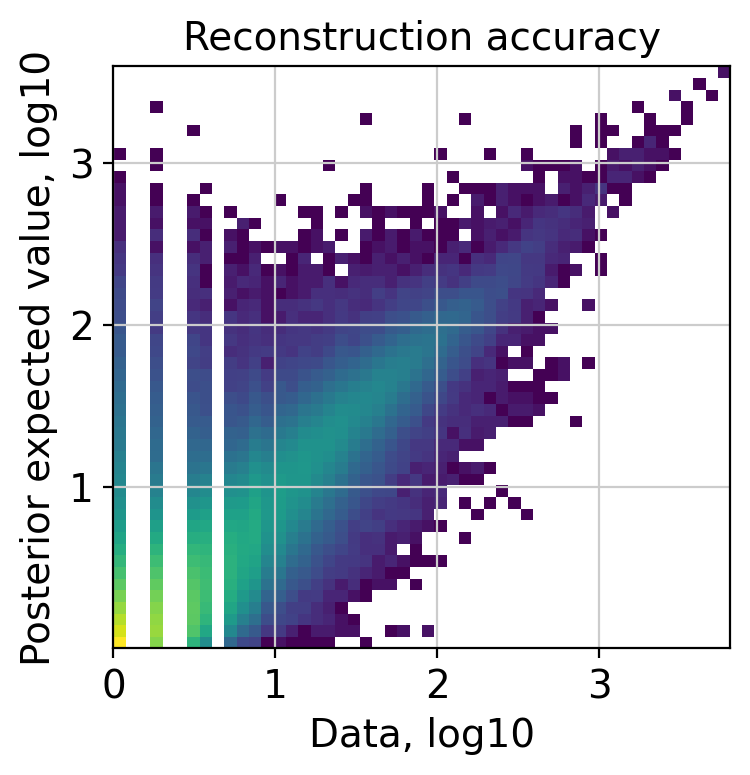

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs}
)
mod.plot_QC()

In [ ]:
fig = mod.plot_spatial_QC_across_batches()
fig

Output hidden; open in https://colab.research.google.com to view.